In [ ]:
import os, json, yaml, joblib, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Dict, Optional

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, log_loss, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
RANDOM_STATE = 42
os.makedirs("artifacts", exist_ok=True)

CONFIG = {

    "label_col": "label_planet",
    "raw_cols_required": [
        "tfopwg_disp",
        "pl_orbper", "pl_trandurh", "pl_trandep",
        "pl_rade", "pl_insol", "pl_eqt",
        "st_tmag", "st_dist", "st_teff", "st_logg", "st_rad",
        "pl_radeerr1"
    ],
    "model_features": [
        "pl_orbper", "pl_trandurh", "pl_trandep",
        "pl_rade", "pl_insol", "pl_eqt",
        "st_tmag", "st_dist", "st_teff", "st_logg", "st_rad",
        "pl_rade_relerr"
    ],

    "log_features_default": [
        "pl_orbper", "pl_trandurh", "pl_trandep",
        "pl_rade", "pl_insol", "pl_eqt",
        "st_dist", "st_teff", "st_rad"
    ],
    "never_log": ["st_logg", "st_tmag", "pl_rade_relerr"],

    "imputer": {"kind": "knn", "k": 5},
    "scaler": "standard",

    "model": {"name": "xgboost", "params": {
        "n_estimators": 500, "max_depth": 4, "learning_rate": 0.08,
        "subsample": 0.8, "colsample_bytree": 0.8, "eval_metric": "logloss"
    }},
    "cv_folds": 5,
    "calibration": {"enabled": True, "method": "isotonic"},
}

with open("artifacts/config.yaml", "w") as f:
    yaml.safe_dump(CONFIG, f)

In [ ]:
def clean_tess_df(raw: pd.DataFrame) -> pd.DataFrame:
    missing = [c for c in CONFIG["raw_cols_required"] if c not in raw.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    d = raw[CONFIG["raw_cols_required"]].copy()

    d["tfopwg_disp"] = d["tfopwg_disp"].astype(str).str.upper()
    d = d[d["tfopwg_disp"] != "PC"].copy()

    d["label_planet"] = np.where(d["tfopwg_disp"].isin(["CP", "KP"]), 1, 0).astype(int)
    d = d.drop(columns=["tfopwg_disp"])

    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = d["pl_radeerr1"] / d["pl_rade"]
        ratio = ratio.replace([np.inf, -np.inf], np.nan)
        d["pl_rade_relerr"] = np.log(ratio)

    d = d.drop(columns=["pl_radeerr1"])

    return d

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Apply ln(x + shift) to selected columns.
    Parameters are stored verbatim in __init__ (sklearn clone-safe).
    Any conversions (e.g., set/list) happen in fit().
    """
    def __init__(self, columns='auto', exclude=None, keep_suffix=False, eps=1e-12):
        self.columns = columns           
        self.exclude = exclude           
        self.keep_suffix = keep_suffix   
        self.eps = eps                   

    def _auto_select(self, X: pd.DataFrame):
        candidates = [
            "pl_orbper", "pl_trandurh", "pl_trandep",
            "pl_rade", "pl_insol", "pl_eqt",
            "st_dist", "st_teff", "st_rad",
        ]
        return [c for c in candidates if c in X.columns]

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        self._exclude_ = set(self.exclude) if self.exclude is not None else set()

        if self.columns == 'auto':
            cols = self._auto_select(X)
        else:
            cols = [c for c in self.columns if c in X.columns]

        cols = [c for c in cols if c not in self._exclude_]

        self.shifts_ = {}
        self.cols_to_log_ = []
        for c in cols:
            x = X[c].astype(float).to_numpy()
            m = np.nanmin(x)
            shift = (-m + self.eps) if np.isfinite(m) and m <= 0 else 0.0

            if not np.any(np.isfinite(x + shift)) or np.nanmax(x + shift) <= 0:
                continue
            self.shifts_[c] = shift
            self.cols_to_log_.append(c)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for c in self.cols_to_log_:
            shift = self.shifts_[c]
            logged = np.log(X[c].astype(float) + shift)
            if self.keep_suffix:
                X[f"log_{c}"] = logged
            else:
                X[c] = logged
        return X

In [ ]:
def make_imputer():
    if CONFIG["imputer"]["kind"] == "knn":
        return KNNImputer(n_neighbors=CONFIG["imputer"]["k"])
    return SimpleImputer(strategy=CONFIG["imputer"].get("strategy", "median"))

def make_scaler():
    return StandardScaler() if CONFIG["scaler"] == "standard" else "passthrough"

def make_model():
    name = CONFIG["model"]["name"]
    p = CONFIG["model"]["params"]
    if name == "logreg":
        return LogisticRegression(
            penalty="l2", C=p.get("C", 1.0), solver="lbfgs",
            max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "rf":
        return RandomForestClassifier(
            n_estimators=p.get("n_estimators", 600),
            max_depth=p.get("max_depth", None),
            min_samples_leaf=p.get("min_samples_leaf", 2),
            class_weight="balanced_subsample",
            n_jobs=-1, random_state=RANDOM_STATE
        )
    if name == "xgboost":
        import xgboost as xgb
        return xgb.XGBClassifier(
            n_estimators=p.get("n_estimators", 500),
            max_depth=p.get("max_depth", 4),
            learning_rate=p.get("learning_rate", 0.08),
            subsample=p.get("subsample", 0.8),
            colsample_bytree=p.get("colsample_bytree", 0.8),
            eval_metric=p.get("eval_metric", "logloss"),
            tree_method="hist",
            random_state=RANDOM_STATE
        )
    raise ValueError("Unknown model name")

def make_pipeline(features_to_log='auto'):
    numeric_features = CONFIG["model_features"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", make_imputer()),
                ("log", LogTransformer(columns=features_to_log, exclude=CONFIG["never_log"], keep_suffix=False)),
                ("scaler", make_scaler()),
            ]), numeric_features),
        ],
        remainder="drop"
    )
    clf = make_model()
    return Pipeline([("preprocess", pre), ("model", clf)])


In [ ]:
RAW_PATH = "/content/tess.csv"  
raw = pd.read_csv(RAW_PATH, comment = "#")

tess_model = clean_tess_df(raw)
X = tess_model[CONFIG["model_features"]].copy()
y = tess_model[CONFIG["label_col"]].astype(int).values

print("Rows:", len(X), "| Positives:", int(y.sum()), "| Negatives:", int((1-y).sum()))
X.head()

Rows: 3021 | Positives: 1266 | Negatives: 1755


,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad,pl_rade_relerr
0,2.171348,2.01722,656.886099,5.818163,22601.948581,3127.204052,9.604000,485.735,10249.0,4.19,2.16986,-1.113595
2,1.867557,1.40800,1500.000000,23.752900,2860.610000,2037.000000,9.299501,943.109,8924.0,NaN,5.73000,NaN
3,2.743230,3.16700,383.410000,NaN,1177.360000,1631.000000,9.300300,7728.170,5388.5,4.15,NaN,NaN
4,3.573014,3.37000,755.000000,11.311300,54679.300000,4260.000000,9.135500,356.437,9219.0,4.14,2.15000,-1.248028
5,4.550594,2.65400,3731.000000,7.108410,414.775000,1257.000000,9.130900,100.711,5613.0,NaN,1.09000,-2.706538


In [ ]:
def eval_metrics(y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, proba),
        "pr_auc": average_precision_score(y_true, proba),
        "f1": f1_score(y_true, pred, zero_division=0),
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "logloss": log_loss(y_true, proba, labels=[0,1]),
    }

skf = StratifiedKFold(n_splits=CONFIG["cv_folds"], shuffle=True, random_state=RANDOM_STATE)
pipe = make_pipeline(features_to_log='auto')

oof = np.zeros(len(X), dtype=float)
fold_metrics = []

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y[tr], y[va]

    pipe.fit(X_tr, y_tr)
    proba_va = pipe.predict_proba(X_va)[:,1]

    if CONFIG["calibration"]["enabled"]:
        cal = CalibratedClassifierCV(pipe, method=CONFIG["calibration"]["method"], cv="prefit")
        cal.fit(X_va, y_va)
        proba_va = cal.predict_proba(X_va)[:,1]

    oof[va] = proba_va
    m = eval_metrics(y_va, proba_va)
    fold_metrics.append(m)
    print(f"Fold {fold}: " + ", ".join([f"{k}={m[k]:.3f}" for k in ["roc_auc","pr_auc","f1","precision","recall","logloss"]]))

overall = eval_metrics(y, oof)
print("\nOOF:", {k: round(v,3) for k,v in overall.items()})

Fold 1: roc_auc=0.914, pr_auc=0.857, f1=0.807, precision=0.762, recall=0.858, logloss=0.357
Fold 2: roc_auc=0.924, pr_auc=0.870, f1=0.826, precision=0.810, recall=0.842, logloss=0.337
Fold 3: roc_auc=0.919, pr_auc=0.858, f1=0.839, precision=0.807, recall=0.874, logloss=0.344
Fold 4: roc_auc=0.930, pr_auc=0.889, f1=0.850, precision=0.818, recall=0.885, logloss=0.319
Fold 5: roc_auc=0.921, pr_auc=0.867, f1=0.833, precision=0.769, recall=0.909, logloss=0.338

OOF: {'roc_auc': np.float64(0.924), 'pr_auc': np.float64(0.883), 'f1': 0.831, 'precision': 0.792, 'recall': 0.874, 'logloss': 0.339}


In [ ]:
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

final_pipe = make_pipeline(features_to_log='auto')
final_pipe.fit(X_tr, y_tr)

if CONFIG["calibration"]["enabled"]:
    calibrated = CalibratedClassifierCV(
        estimator=final_pipe,  
        method=CONFIG["calibration"]["method"],
        cv="prefit"
    )
    calibrated.fit(X_va, y_va)
    model_to_save = calibrated
else:
    model_to_save = final_pipe

os.makedirs("artifacts", exist_ok=True)
joblib.dump(model_to_save, "artifacts/model.joblib")

def _get_base_pipeline(model, fallback):
    """
    For CalibratedClassifierCV, return the wrapped estimator if available,
    else fall back to the provided pipeline we just fitted (final_pipe).
    """
    try:
        from sklearn.calibration import CalibratedClassifierCV
        if isinstance(model, CalibratedClassifierCV):

            if hasattr(model, "estimator") and model.estimator is not None:
                return model.estimator
            if hasattr(model, "base_estimator") and model.base_estimator is not None:
                return model.base_estimator
            return fallback
        return model
    except Exception:
        return fallback

base_pipe = _get_base_pipeline(model_to_save, final_pipe)

try:
    pre = base_pipe.named_steps["preprocess"]
    num_pipe = pre.named_transformers_["num"]
    log_step = num_pipe.named_steps["log"]
    cols_logged = getattr(log_step, "cols_to_log_", [])
    shifts = getattr(log_step, "shifts_", {})
except Exception as e:
    cols_logged, shifts = [], {}
    print("Warning: could not extract LogTransformer details:", repr(e))

with open("artifacts/log_transform.json", "w") as f:
    json.dump(
        {
            "columns_logged": cols_logged,
            "shifts": shifts,               
            "exclude_never": CONFIG["never_log"],
        },
        f,
        indent=2,
    )

with open("artifacts/features.json", "w") as f:
    json.dump(
        {
            "model_features": CONFIG["model_features"],
            "log_policy": "auto",
            "calibrated": bool(CONFIG["calibration"]["enabled"]),
            "classifier": CONFIG["model"]["name"],
            "classifier_params": CONFIG["model"]["params"],
            "imputer": CONFIG["imputer"],
            "scaler": CONFIG["scaler"],
            "cv_folds": CONFIG["cv_folds"],
            "random_state": RANDOM_STATE,
        },
        f,
        indent=2,
    )

print("Saved:")
print("  - artifacts/model.joblib")
print("  - artifacts/log_transform.json")
print("  - artifacts/features.json")

Saved:
  - artifacts/model.joblib
  - artifacts/log_transform.json
  - artifacts/features.json


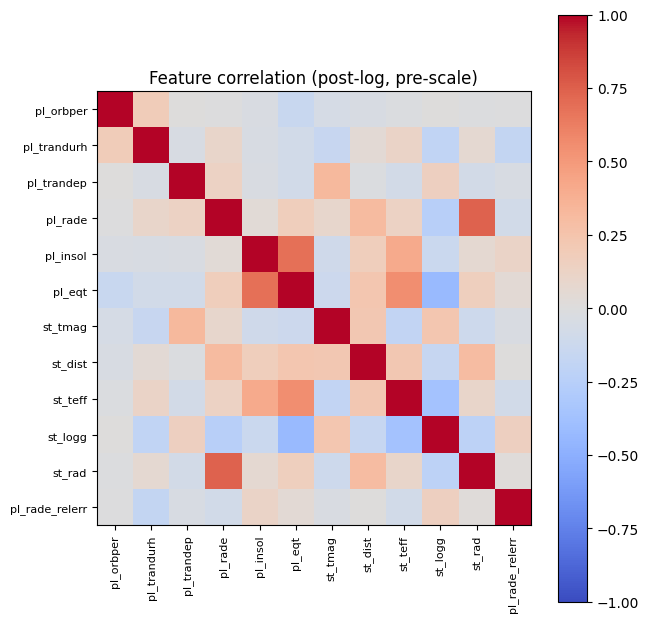

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

def _get_base_pipeline(model, fallback):
    if isinstance(model, CalibratedClassifierCV):

        if hasattr(model, "estimator") and model.estimator is not None:
            return model.estimator
        if hasattr(model, "base_estimator") and model.base_estimator is not None:
            return model.base_estimator
        return fallback
    return model

try:
    model_loaded = joblib.load("artifacts/model.joblib")
except Exception:
    model_loaded = final_pipe  

base_pipe = _get_base_pipeline(model_loaded, final_pipe)

pre = base_pipe.named_steps["preprocess"]
num_pipe = pre.named_transformers_["num"]

imputer = num_pipe.named_steps["imputer"]
log_step = num_pipe.named_steps["log"]

Xt_imp = imputer.transform(X)

Xt_imp = pd.DataFrame(Xt_imp, columns=CONFIG["model_features"])

Xt_logged = log_step.transform(Xt_imp)  

std = Xt_logged.std(numeric_only=True)
non_const_cols = std[std > 0].index.tolist()
Xt_logged = Xt_logged[non_const_cols]

if Xt_logged.shape[1] == 0:
    print("All features are constant after impute/log; nothing to plot.")
else:

    corr = Xt_logged.corr(numeric_only=True).fillna(0.0)

    plt.figure(figsize=(max(6, 0.55*len(non_const_cols)), max(5, 0.55*len(non_const_cols))))
    im = plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr.index)), corr.index, fontsize=8)
    plt.colorbar(im)
    plt.title("Feature correlation (post-log, pre-scale)")
    plt.tight_layout()
    plt.show()

In [ ]:
name = CONFIG["model"]["name"]
clf_pipe = base_pipe  

if name == "logreg":
    clf = clf_pipe.named_steps["model"]
    coefs = clf.coef_.ravel()
    fi = pd.Series(coefs, index=CONFIG["model_features"]).sort_values(key=np.abs, ascending=False)
    print("LogReg |coef| top-10:\n", fi.head(10))
elif name == "rf":
    clf = clf_pipe.named_steps["model"]
    fi = pd.Series(clf.feature_importances_, index=CONFIG["model_features"]).sort_values(ascending=False)
    print("RF importances top-10:\n", fi.head(10))
elif name == "xgboost":
    clf = clf_pipe.named_steps["model"]
    booster = clf.get_booster()
    fmap = {f"f{i}": CONFIG["model_features"][i] for i in range(len(CONFIG["model_features"]))}
    gain = booster.get_score(importance_type="gain")
    gain_named = pd.Series({fmap[k]: v for k, v in gain.items()}).sort_values(ascending=False)
    print("XGB gain top-10:\n", gain_named.head(10))

XGB gain top-10:
 pl_eqt            4.969738
pl_rade_relerr    4.066185
pl_rade           3.941189
st_dist           3.495094
pl_trandurh       3.078345
st_rad            2.698777
pl_orbper         2.588894
pl_trandep        2.534914
st_teff           2.481596
st_tmag           2.204651
dtype: float64


API HELPERS

In [ ]:
def preprocess_for_inference(df_new: pd.DataFrame) -> pd.DataFrame:
    """
    Recreate the same engineered table as training:
    - R-style cleaning run beforehand when you built tess_model
    - Here we assume df_new ALREADY has the same model_features columns.
    (If you want to accept raw TESS and re-run clean_tess_df, call that first.)
    """
    missing = [c for c in CONFIG["model_features"] if c not in df_new.columns]
    if missing:
        raise ValueError(f"Missing model features at inference: {missing}")
    return df_new[CONFIG["model_features"]].copy()

def predict_proba_on_csv(csv_path: str) -> pd.DataFrame:
    model = joblib.load("artifacts/model.joblib")
    df_new_raw = pd.read_csv(csv_path, comment = "#")

    if set(CONFIG["raw_cols_required"]).issubset(df_new_raw.columns):
        df_new = clean_tess_df(df_new_raw)
    else:
        df_new = df_new_raw  

    X_new = preprocess_for_inference(df_new)
    proba = model.predict_proba(X_new)[:,1]
    out = df_new.copy()
    out["prob_exoplanet"] = proba
    return out

preds = predict_proba_on_csv("/content/tess.csv")
preds.head()

,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad,label_planet,pl_rade_relerr,prob_exoplanet
0,2.171348,2.01722,656.886099,5.818163,22601.948581,3127.204052,9.604000,485.735,10249.0,4.19,2.16986,0,-1.113595,0.000000
2,1.867557,1.40800,1500.000000,23.752900,2860.610000,2037.000000,9.299501,943.109,8924.0,NaN,5.73000,0,NaN,0.000000
3,2.743230,3.16700,383.410000,NaN,1177.360000,1631.000000,9.300300,7728.170,5388.5,4.15,NaN,0,NaN,0.010989
4,3.573014,3.37000,755.000000,11.311300,54679.300000,4260.000000,9.135500,356.437,9219.0,4.14,2.15000,0,-1.248028,0.000000
5,4.550594,2.65400,3731.000000,7.108410,414.775000,1257.000000,9.130900,100.711,5613.0,NaN,1.09000,0,-2.706538,0.395349


In [ ]:
from sklearn.mixture import GaussianMixture

if CONFIG["type_model"]["enabled"]:

    planets = tess_model[tess_model[CONFIG["label_col"]] == 1].copy()
    Xp = planets[CONFIG["model_features"]].copy()

    type_pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", make_imputer()),
                ("log", LogTransformer(columns='auto', exclude=CONFIG["never_log"], keep_suffix=False)),
                ("scaler", make_scaler()),
            ]), CONFIG["model_features"])
        ],
        remainder="drop"
    )
    Zp = type_pre.fit_transform(Xp)
    joblib.dump(type_pre, "artifacts/type_preprocessor.joblib")

    Ks = range(2, CONFIG["type_model"]["k_max"]+1)
    models = [GaussianMixture(k, covariance_type="full", random_state=RANDOM_STATE).fit(Zp) for k in Ks]
    bics = [m.bic(Zp) for m in models]
    k_best = Ks[int(np.argmin(bics))]
    gmm = models[int(np.argmin(bics))]
    joblib.dump(gmm, f"artifacts/type_gmm_k{k_best}.joblib")

    print("Type model saved. BIC by k:", dict(zip(Ks, np.round(bics,1))))

Type model saved. BIC by k: {2: np.float64(23042.0), 3: np.float64(16208.7), 4: np.float64(15244.5), 5: np.float64(13853.6), 6: np.float64(12855.6), 7: np.float64(11472.4), 8: np.float64(10484.2)}


In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_report(y_true, proba, thr=0.5):
    """
    Build a JSON-friendly confusion matrix report at a given threshold.

    Returns:
      {
        "threshold": 0.50,
        "counts": {"TP":..,"TN":..,"FP":..,"FN":..},
        "rates":  {"TPR":..,"TNR":..,"FPR":..,"FNR":..,"PPV":..,"NPV":..,"ACC":..},
        "matrix": [[TN, FP],
                   [FN, TP]]
      }
    """
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba).astype(float)
    pred = (proba >= thr).astype(int)

    cm = confusion_matrix(y_true, pred, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()

    def safe_div(a, b): return float(a) / float(b) if b else 0.0

    P = TP + FN  
    N = TN + FP  

    report = {
        "threshold": float(thr),
        "counts": {
            "TP": int(TP), "TN": int(TN), "FP": int(FP), "FN": int(FN),
            "P": int(P), "N": int(N)
        },
        "rates": {
            "TPR": safe_div(TP, P),               
            "TNR": safe_div(TN, N),               
            "FPR": safe_div(FP, N),
            "FNR": safe_div(FN, P),
            "PPV": safe_div(TP, TP + FP),         
            "NPV": safe_div(TN, TN + FN),
            "ACC": safe_div(TP + TN, P + N),
        },
        "matrix": cm.tolist()  
    }
    return report

# KMEANS TO LABEL OUR DATA TO BE USED FOR KNN LATER FOR

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv("/content/tess.csv", comment="#")

if "tfopwg_disp" not in df.columns:
    raise ValueError("Expected column 'tfopwg_disp' not found in the CSV.")

planets = df[df["tfopwg_disp"].astype(str).str.upper().isin(["CP", "KP"])].copy()

feat_cols = ["pl_rade", "pl_insol", "pl_eqt", "pl_orbper", "st_teff", "st_rad"]
feat_cols = [c for c in feat_cols if c in planets.columns]
X = planets[feat_cols].copy()

def log_safe(s: pd.Series, eps=1e-12):
    s = s.astype(float)
    m = np.nanmin(s.values)
    shift = (-m + eps) if np.isfinite(m) and m <= 0 else 0.0
    return np.log(s + shift)

log_cols = [c for c in ["pl_rade","pl_insol","pl_eqt","pl_orbper","st_teff","st_rad"] if c in X.columns]
for c in log_cols:
    X[c] = log_safe(X[c])

X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
Z = scaler.fit_transform(X)

km = KMeans(n_clusters=2, n_init=50, random_state=42)
labels_planets = km.fit_predict(Z)

df_out = df.copy()
df_out.loc[planets.index, "kmeans_label"] = labels_planets

print("Planet rows clustered:", len(planets))
print("Cluster counts among planets:")
print(pd.Series(labels_planets).value_counts().sort_index())

Planet rows clustered: 1266
Cluster counts among planets:
0    766
1    500
Name: count, dtype: int64


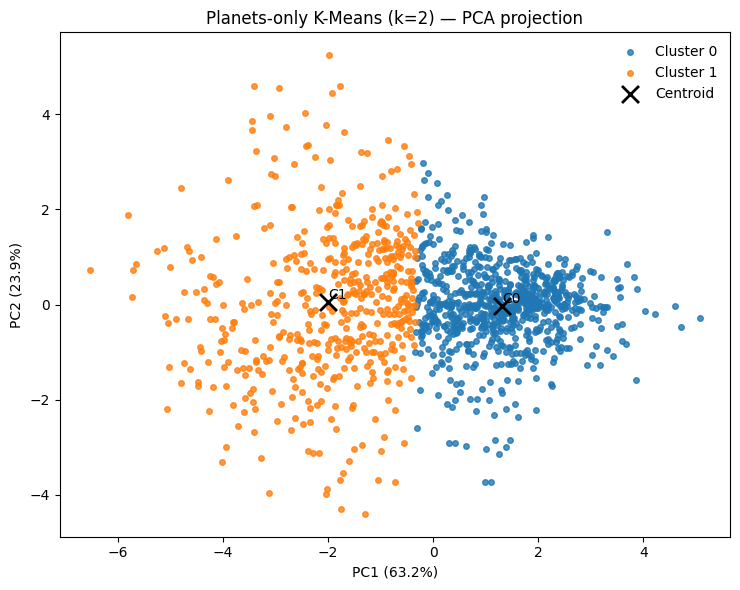

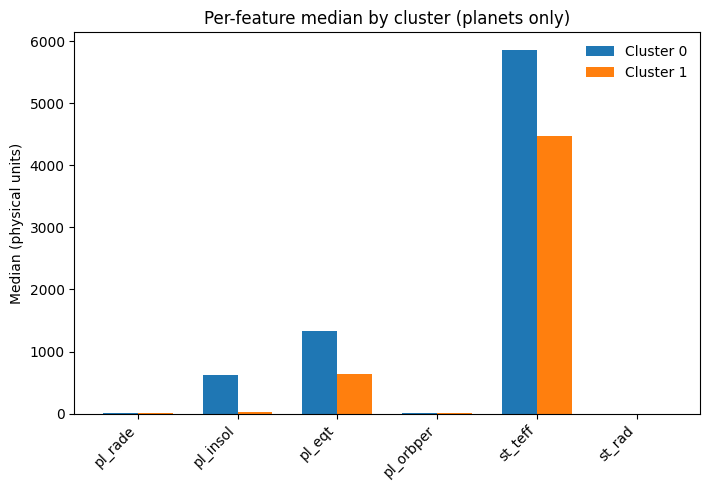

In [ ]:
pca = PCA(n_components=2, random_state=42)
scores = pca.fit_transform(Z)
centers_2d = pca.transform(km.cluster_centers_)

plt.figure(figsize=(7.5, 6))
for k in np.unique(labels_planets):
    idx = (labels_planets == k)
    plt.scatter(scores[idx, 0], scores[idx, 1], s=16, alpha=0.8, label=f"Cluster {k}")
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker="x", s=150, linewidths=2, c="black", label="Centroid")
for i, (cx, cy) in enumerate(centers_2d):
    plt.text(cx, cy, f"C{i}", fontsize=10, ha="left", va="bottom")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Planets-only K-Means (k=2) — PCA projection")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

planets_plot = planets.copy()
planets_plot["_cluster"] = labels_planets

logged_cols = [c for c in feat_cols if c in X.columns]   

phys = pd.DataFrame(index=planets.index)
for c in feat_cols:
    if c in logged_cols:

        phys[c] = np.exp(X.loc[planets.index, c].values)
    else:

        phys[c] = planets[c].values

phys["_cluster"] = labels_planets

medians = phys.groupby("_cluster")[feat_cols].median(numeric_only=True).T

plt.figure(figsize=(max(7, 1.2*len(feat_cols)), 5))
x = np.arange(len(medians.index))
width = 0.35
plt.bar(x - width/2, medians[0], width, label="Cluster 0")
plt.bar(x + width/2, medians[1], width, label="Cluster 1")
plt.xticks(x, medians.index, rotation=45, ha="right")
plt.ylabel("Median (physical units)")
plt.title("Per-feature median by cluster (planets only)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
df_out.to_csv("artifacts/type_labels.csv")
df_out

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate,kmeans_label
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,0.07,-0.07,0,2.169860,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01,NaN
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,0.09,-0.09,0,2.010000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04,NaN
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,0,5.730000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02,NaN
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02,NaN
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,0.07,-0.07,0,2.150000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,995.01,317951248,FP,07h23m14.75s,110.811443,+05d33m46.26s,5.562850,2.061,0.405,-0.405,...,NaN,NaN,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2021-10-29 12:59:15,NaN
7695,996.01,142918609,FP,07h57m23.99s,119.349948,-19d30m57.65s,-19.516015,-3.900,0.848,-0.848,...,NaN,NaN,0,2.050000,NaN,NaN,0,2019-07-24 15:58:33,2021-10-29 12:59:15,NaN
7696,997.01,341729521,FP,08h05m16.69s,121.319521,-59d34m47.27s,-59.579798,-44.770,0.044,-0.044,...,0.08,-0.08,0,0.926261,0.045789,-0.045789,0,2019-07-24 15:58:33,2024-09-09 10:08:01,NaN
7697,998.01,54390047,FP,07h53m16.69s,118.319555,-14d13m07.76s,-14.218823,-1.706,0.069,-0.069,...,0.07,-0.07,0,2.349860,0.091578,-0.091578,0,2019-07-24 15:58:33,2024-09-09 10:08:01,NaN


In [ ]:
IN_PATH  = "/content/tess.csv"                  
OUT_PATH = "type_labels_inferred.csv"           

CONFIG = {
    "ground_truth_path": "artifacts/type_labels.csv",  
    "label_col": "kmeans_label",           
    "features": [
        "pl_rade","pl_bmasse","pl_insol","pl_eqt",
        "pl_orbper","pl_orbsmax","st_teff","st_rad"
    ],
    "add_density": True,                   
    "imputer": {"kind": "knn", "n_neighbors": 5, "weights": "distance"},  
    "max_missing_frac": 0.5,               
    "knn_k": 5,                            
    "prob_threshold_unknown": 0.60,        
    "label_name_map": {0: "Gas", 1: "Rocky"},
}

def build_X(df: pd.DataFrame, features: list, add_density: bool) -> pd.DataFrame:
    X = df[[c for c in features if c in df.columns]].copy()
    if add_density and {"pl_bmasse","pl_rade"}.issubset(X.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            X["pl_dens"] = 5.514 * (X["pl_bmasse"] / (X["pl_rade"]**3))
    return X

def autodetect_label_col(df: pd.DataFrame) -> str:
    candidates = ["type_label","type_cluster","kmeans_label","planet_type","type","label"]
    for c in candidates:
        if c in df.columns:
            vals = pd.to_numeric(df[c], errors="coerce").dropna().unique()
            if set(pd.Series(vals).astype(int)).issubset({0,1}):
                return c
    raise ValueError(
        "Could not find a 0/1 label column in ground-truth. "
        "Set CONFIG['label_col'] or include one of: "
        "type_label, type_cluster, kmeans_label, planet_type, type, label"
    )

def make_preprocessor(cfg: dict):
    """Return a Pipeline(imputer -> scaler) fit later on GT."""
    imp_cfg = cfg["imputer"]
    if imp_cfg.get("kind", "knn") == "knn":
        imputer = KNNImputer(
            n_neighbors=imp_cfg.get("n_neighbors", 5),
            weights=imp_cfg.get("weights", "uniform")
        )
    else:
        imputer = SimpleImputer(strategy="median")
    return Pipeline([("imp", imputer), ("scaler", StandardScaler())])

def fit_knn_from_gt(gt: pd.DataFrame, cfg: dict):
    """Fit Imputer+Scaler (on GT) and a KNN classifier on GT labels."""
    label_col = cfg["label_col"] or autodetect_label_col(gt)
    X_gt_all = build_X(gt, cfg["features"], cfg["add_density"])
    if X_gt_all.empty:
        raise ValueError("None of the configured FEATURES exist in ground-truth file.")

    max_miss = cfg["max_missing_frac"]
    miss_frac = X_gt_all.isna().mean(axis=1)
    mask_row_ok = miss_frac <= max_miss
    X_gt = X_gt_all.loc[mask_row_ok]
    y_gt = pd.to_numeric(gt.loc[mask_row_ok, label_col], errors="coerce")

    mask_label_ok = y_gt.isin([0,1])
    X_gt = X_gt.loc[mask_label_ok]
    y_gt = y_gt.loc[mask_label_ok].astype(int).values

    if X_gt.empty:
        raise ValueError("No GT rows left after missingness and label checks.")

    pre = make_preprocessor(cfg)
    Z_gt = pre.fit_transform(X_gt.values)

    clf = KNeighborsClassifier(n_neighbors=cfg["knn_k"], weights="distance")
    clf.fit(Z_gt, y_gt)
    return pre, clf

def apply_inference(df_new: pd.DataFrame, pre, clf, cfg: dict) -> pd.DataFrame:
    X_new_all = build_X(df_new, cfg["features"], cfg["add_density"])

    max_miss = cfg["max_missing_frac"]
    miss_frac = X_new_all.isna().mean(axis=1)
    idx_ok = miss_frac.index[miss_frac <= max_miss]
    idx_bad = miss_frac.index[miss_frac > max_miss]

    out = df_new.copy()
    if len(idx_ok) > 0:
        Z = pre.transform(X_new_all.loc[idx_ok].values)  
        probs = clf.predict_proba(Z)
        preds = probs.argmax(axis=1).astype(int)
        conf  = probs.max(axis=1)

        preds = np.where(conf < cfg["prob_threshold_unknown"], -1, preds)

        out.loc[idx_ok, "type_pred"] = preds
        out.loc[idx_ok, "type_confidence"] = conf
        out.loc[idx_ok, "type_name"] = pd.Series(preds, index=idx_ok).map(
            {**cfg["label_name_map"], -1: "Unknown"}
        )

    if len(idx_bad) > 0:
        out.loc[idx_bad, ["type_pred","type_confidence","type_name"]] = [np.nan, np.nan, np.nan]

    return out

gt_path = Path(CONFIG["ground_truth_path"])
if not gt_path.exists():
    raise FileNotFoundError(f"Ground-truth file not found: {gt_path}")
gt = pd.read_csv(gt_path) if gt_path.suffix.lower()==".csv" else pd.read_parquet(gt_path)

pre, knn = fit_knn_from_gt(gt, CONFIG)

df_new = pd.read_csv(IN_PATH, comment="#") if IN_PATH.endswith(".csv") else pd.read_parquet(IN_PATH)

typed_new = apply_inference(df_new, pre, knn, CONFIG)

typed_new.to_csv(OUT_PATH, index=False)
print(f"Saved: {OUT_PATH}")

print("\nCounts by type_pred (NaN = missing features):")
print(typed_new["type_pred"].value_counts(dropna=False).sort_index())

if "type_name" in typed_new.columns:
    print("\nCounts by type_name:")
    print(typed_new["type_name"].value_counts(dropna=False))

Saved: type_labels_inferred.csv

Counts by type_pred (NaN = missing features):
type_pred
-1.0      96
 0.0    5552
 1.0    1900
 NaN     151
Name: count, dtype: int64

Counts by type_name:
type_name
Gas        5552
Rocky      1900
NaN         151
Unknown      96
Name: count, dtype: int64
